# Softmax exercise


In thsi exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
from __future__ import print_function
import random
import numpy as np
from lib.data_utils import load_CIFAR10
import matplotlib.pyplot as plt



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'lib/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **lib/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file lib/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from lib.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
print(grad)
# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

[[-2.51206165e+00 -1.29182709e+00  1.30952224e+00 ... -5.58390251e-01
  -1.41111249e+00 -4.02455724e+00]
 [-3.63095893e+00 -3.84389366e-01  9.15196154e-01 ... -4.01186860e-01
  -3.11220998e+00 -4.50449378e+00]
 [-6.22116075e+00 -2.71586935e-01  2.24482972e+00 ...  4.26472455e-02
  -5.20099802e+00 -5.45907433e+00]
 ...
 [-1.47400026e+00  6.80809746e-01 -1.74434262e-01 ... -1.42427200e+00
   1.71224315e+00 -1.60703513e+00]
 [-3.20480937e+00 -4.05529165e-02  6.64465791e-01 ...  6.20425225e-01
  -3.12081913e-01 -1.97574523e+00]
 [-1.35786250e-02  2.73502957e-03  7.89315431e-03 ... -1.64585686e-02
   4.73706275e-03  2.56938308e-03]]
loss: 2.342298
sanity check: 2.302585


## Inline Question:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *With reg set to 0 our loss is just L = 1/N sum(Li). Li = -log(Pyi). Since there are 10 possible values for y the probability for each should be .1 after we have gone through the whole dataset. Therefor our loss is L = 1/N sum(-log(0.1)) = -log(0.1)*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from lib.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

(1374, 8)
numerical: -0.432472 analytic: -2.182637, relative error: 6.692512e-01
(1231, 6)
numerical: 0.113547 analytic: 2.300174, relative error: 9.059155e-01
(1814, 9)
numerical: 0.081142 analytic: 1.880237, relative error: 9.172604e-01
(2158, 8)
numerical: -0.138712 analytic: -0.087772, relative error: 2.249175e-01
(837, 9)
numerical: 0.463150 analytic: -0.711185, relative error: 1.000000e+00
(1615, 6)
numerical: -0.024796 analytic: 1.370057, relative error: 1.000000e+00
(2621, 0)
numerical: -0.353800 analytic: -3.995328, relative error: 8.373007e-01
(255, 2)
numerical: -0.403659 analytic: 1.219189, relative error: 1.000000e+00
(209, 0)
numerical: -1.346086 analytic: -5.860667, relative error: 6.264376e-01
(2377, 1)
numerical: 0.287976 analytic: 3.034345, relative error: 8.266415e-01
(2194, 3)
numerical: 0.481770 analytic: -0.292777, relative error: 1.000000e+00
(369, 5)
numerical: 0.820072 analytic: 2.531631, relative error: 5.106536e-01
(2504, 0)
numerical: -0.678468 analytic: -4.

In [123]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from lib.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.342298e+00 computed in 0.078069s
(500, 30730) 500
(30730,)
vectorized loss: 2.342298e+00 computed in 0.149135s
Loss difference: 0.000000
Gradient difference: 0.000000


In [125]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You can experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy close to 0.35 on the validation set.
from lib.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 2.6e4]

# Use the validation set to set the learning rate and regularization strength.
# This is almost identical to the validation that we used for the SVM; save   
# the best trained softmax classifer in best_softmax.                         
grid_search=[(x,y) for x in learning_rates for y in regularization_strengths]

for lr, reg in grid_search:
    softmax=Softmax()
    softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000)
    y_train_pred=softmax.predict(X_train)
    y_val_pred=softmax.predict(X_val)
    train_accuracy=np.mean(y_train_pred==y_train)
    val_accuracy=np.mean(y_val_pred==y_val)
    
    results[lr, reg] = (train_accuracy, val_accuracy)
    
    if val_accuracy > best_val:
        best_val=val_accuracy
        best_softmax=softmax
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % 
                       (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.340408 val accuracy: 0.370000
lr 1.000000e-07 reg 2.600000e+04 train accuracy: 0.337735 val accuracy: 0.357000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.346878 val accuracy: 0.363000
lr 5.000000e-07 reg 2.600000e+04 train accuracy: 0.329673 val accuracy: 0.343000
best validation accuracy achieved during cross-validation: 0.370000


In [126]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.332000


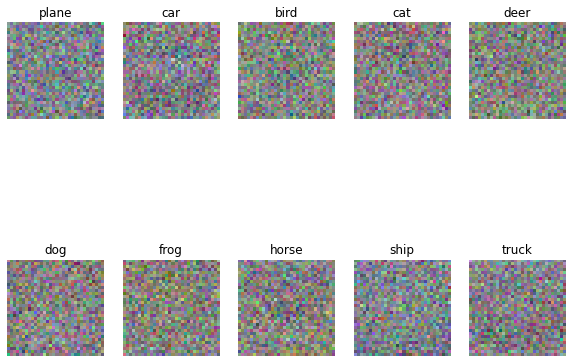

In [127]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i] - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])